## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:
- test rmse: 44798.497576784845
- test r2: 0.7079639526659389

To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.

## "MY MODEL RESULTS: test r2: 0.812, rmse: 35940" 


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

Remember that you need to fork this repo first, upload your winning notebook to your repo, and then make a PR (pull request) to my repo. I will then revise and accept the PR, which will appear in my repo and be available to all the students in the course. This way, other students can learn from your creativity when transforming the variables in your dataset. 

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
from feature_engine import variable_transformers as vt

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../house_train.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print(f'There are {len(numerical)} continuous variables') # just demonstrating use of f-strings :p
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


In [4]:
pos = [] # features that only have positive values, so that we can apply log transformations to it

for c in numerical:
    if data[c].isna().mean() == 0:
        if np.sum(np.where(data[c]<=0, 1, 0)) == 0:
            pos.append(c)
pos

['LotArea', '1stFlrSF', 'GrLivArea']

In [5]:
numerical_minus_pos = []
for c in numerical:
    if c in pos:
        pass
    else:
        numerical_minus_pos.append(c)
numerical_minus_pos

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [6]:
numerical_minus_pos_minus_nan = [] # numerical features that are neither positive nor have nan values 
for c in numerical_minus_pos:
    if data[c].isna().mean() == 0:
        numerical_minus_pos_minus_nan.append(c)

numerical_minus_pos_minus_nan

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [7]:
# adding a small value (0.0001) so that they could be used for box-cox/ yeo-johnson analysis

data[numerical_minus_pos_minus_nan] = data[numerical_minus_pos_minus_nan] + 0.0001
data[numerical_minus_pos_minus_nan].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,706.0001,0.0001,150.0001,856.0001,854.0001,0.0001,548.0001,0.0001,61.0001,0.0001,0.0001,0.0001,0.0001
1,978.0001,0.0001,284.0001,1262.0001,0.0001,0.0001,460.0001,298.0001,0.0001,0.0001,0.0001,0.0001,0.0001
2,486.0001,0.0001,434.0001,920.0001,866.0001,0.0001,608.0001,0.0001,42.0001,0.0001,0.0001,0.0001,0.0001
3,216.0001,0.0001,540.0001,756.0001,756.0001,0.0001,642.0001,0.0001,35.0001,272.0001,0.0001,0.0001,0.0001
4,655.0001,0.0001,490.0001,1145.0001,1053.0001,0.0001,836.0001,192.0001,84.0001,0.0001,0.0001,0.0001,0.0001


In [8]:
numerical_with_nan = [] # finally, numerical values which have nan values 
for c in numerical_minus_pos:
    if data[c].isna().mean()>0:
        numerical_with_nan.append(c)
numerical_with_nan

['LotFrontage', 'MasVnrArea']

### Separate train and test set

In [9]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [10]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Feature Engineering Pipeline

In [13]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [14]:
X_train[numerical].isna().sum()

LotFrontage      233
LotArea            0
MasVnrArea         6
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
MiscVal            0
dtype: int64

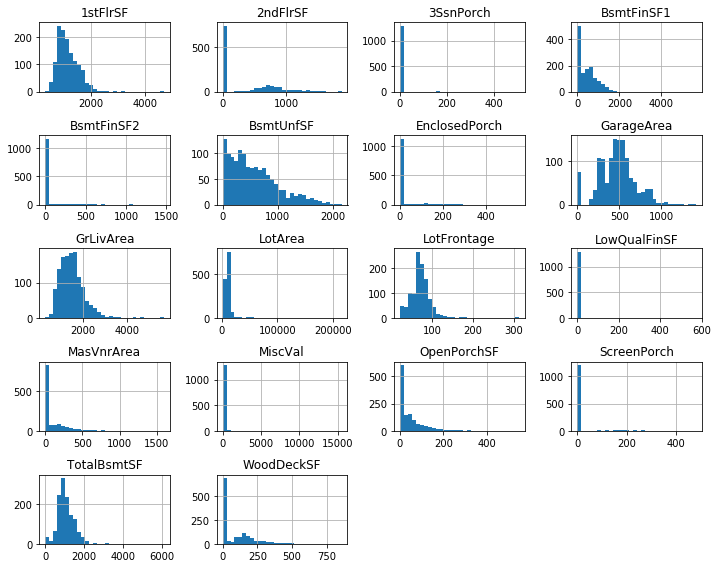

In [15]:
X_train[numerical].hist(bins=30, figsize=(10,8));
plt.tight_layout()

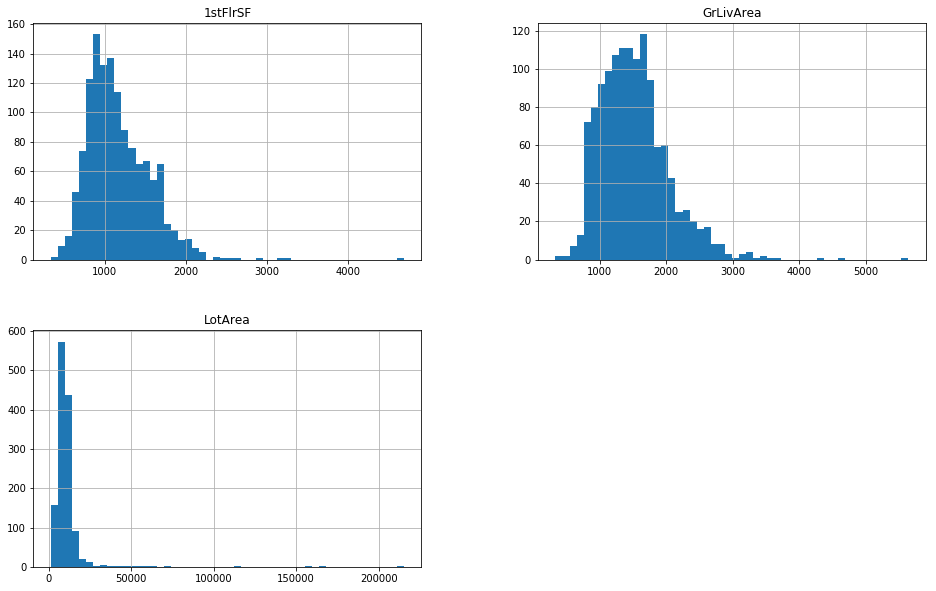

In [16]:
X_train[pos].hist(bins=50, figsize=(16,10));

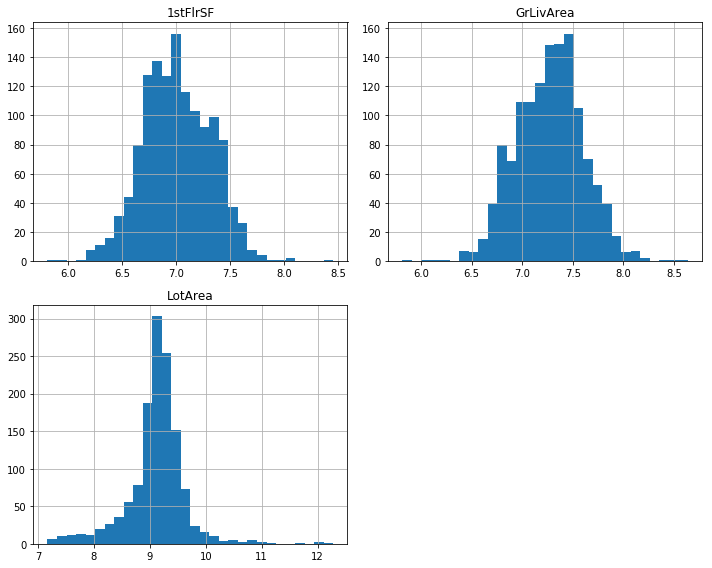

In [17]:
tf = vt.LogTransformer(variables=pos)
tf.fit(X_train[pos])
data_log = tf.transform(X_train[pos])

data_log.hist(bins=30, figsize=(10,8));
plt.tight_layout()

In [18]:
# 1stFlrSF, GrLivArea now have normal distributions after Log transformations
# Lot Area not so much

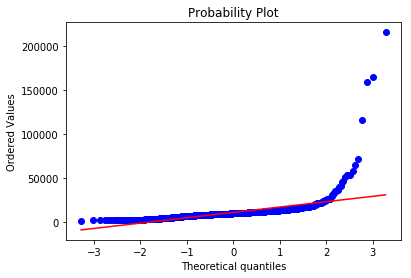

In [19]:
stats.probplot(X_train['LotArea'], plot=plt);

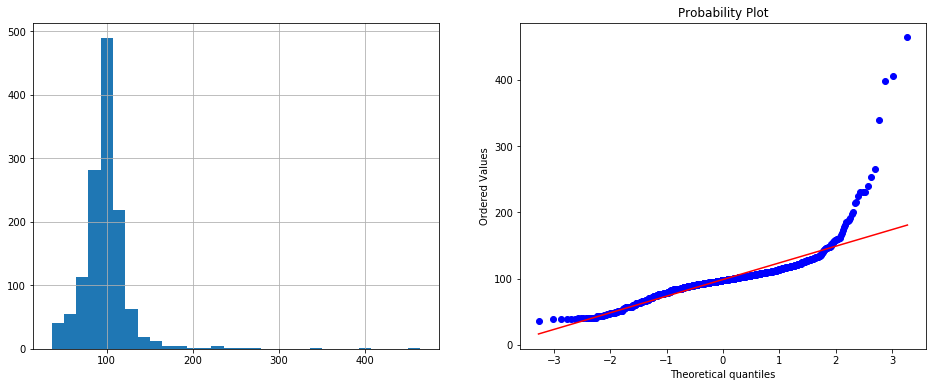

In [20]:
plt.figure(figsize=(16,6))

f = FunctionTransformer(lambda x: np.power(x,0.5), validate=True)
f_t = f.transform(X_train[pos])

plt.subplot(121)
pd.DataFrame(f_t, columns=pos)['LotArea'].hist(bins=30)

plt.subplot(122)
stats.probplot(pd.DataFrame(f_t, columns=pos)['LotArea'], plot=plt);

In [21]:
pos.remove('LotArea') # Hence we suspend LotArea's membership from 'pos' list

In [22]:
pos

['1stFlrSF', 'GrLivArea']

In [23]:
numerical_minus_pos_minus_nan.append('LotArea') # and now add 'LotArea' to this list

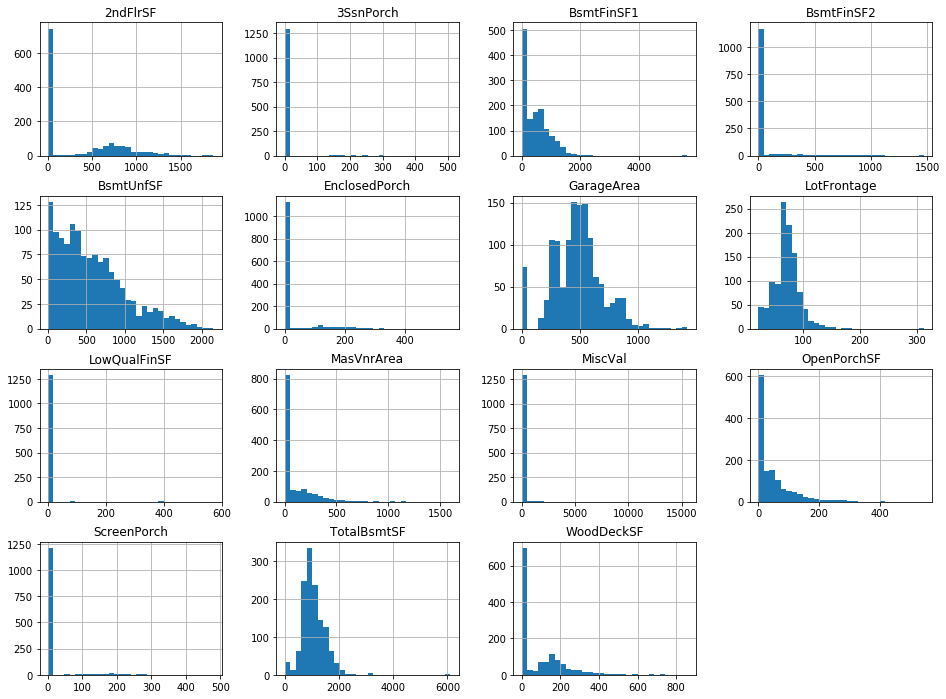

<Figure size 432x288 with 0 Axes>

In [24]:
X_train[numerical_minus_pos].hist(bins=30, figsize=(16,12))
plt.show()
plt.tight_layout()

In [25]:
X_train[numerical_minus_pos_minus_nan].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,LotArea
930,16.0001,0.0001,1450.0001,1466.0001,0.0001,0.0001,610.0001,100.0001,18.0001,0.0001,0.0001,0.0001,0.0001,8925
656,806.0001,0.0001,247.0001,1053.0001,0.0001,0.0001,312.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,10007
45,456.0001,0.0001,1296.0001,1752.0001,0.0001,0.0001,576.0001,196.0001,82.0001,0.0001,0.0001,0.0001,0.0001,7658
1348,1443.0001,0.0001,39.0001,1482.0001,0.0001,0.0001,514.0001,402.0001,25.0001,0.0001,0.0001,0.0001,0.0001,16196
55,490.0001,0.0001,935.0001,1425.0001,0.0001,0.0001,576.0001,0.0001,0.0001,0.0001,407.0001,0.0001,0.0001,10175


C:\Users\Rachit\Anaconda3\lib\site-packages\feature_engine\variable_transformers.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[var] = X[var].astype('float') # to avoid NumPy error
C:\Users\Rachit\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1458: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\Rachit\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
C:\Users\Rachit\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
C:\Users\Rachit\Anaconda3\l

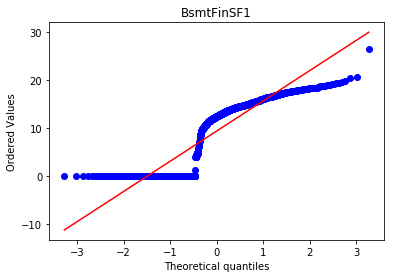

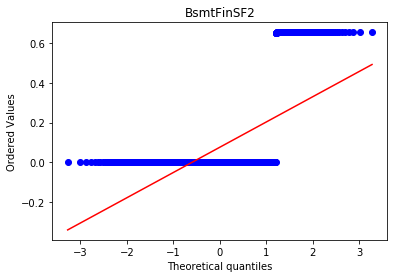

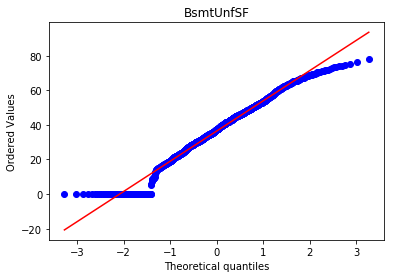

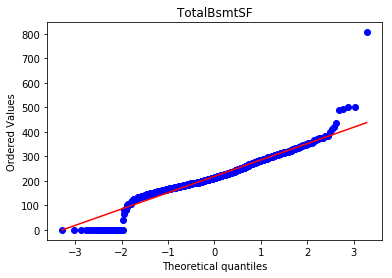

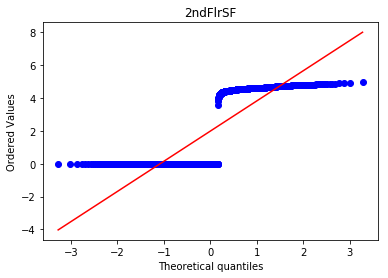

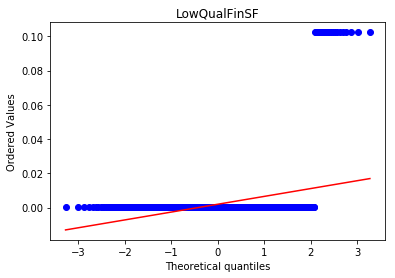

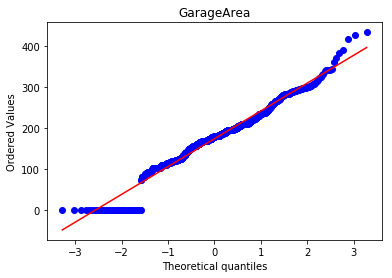

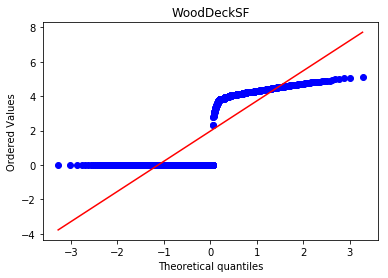

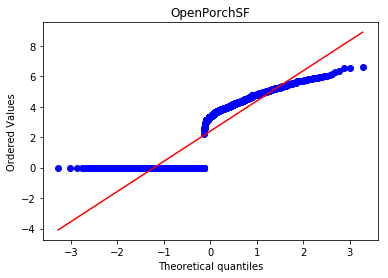

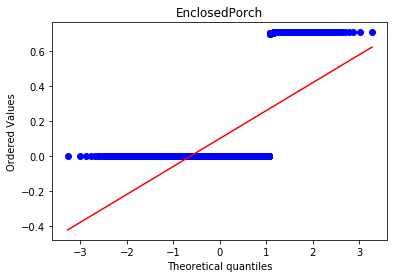

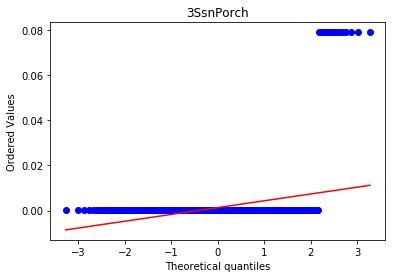

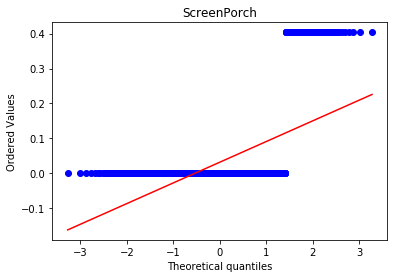

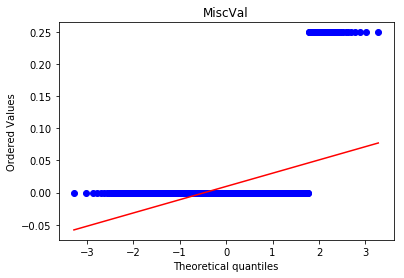

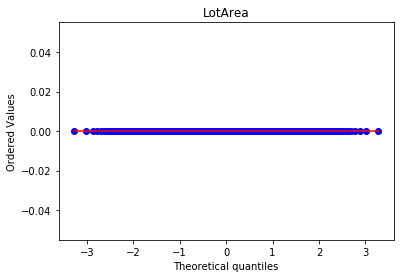

<Figure size 432x288 with 0 Axes>

In [26]:
tf1 = vt.YeoJohnsonTransformer(variables=numerical_minus_pos_minus_nan)
tf1.fit(X_train[numerical_minus_pos_minus_nan])
data_yj = tf1.transform(X_train[numerical_minus_pos_minus_nan])

for col in data_yj:
    stats.probplot(data_yj[col], plot=plt);
    plt.title(col)
    plt.show()
plt.tight_layout()

In [27]:
data_yj = ['TotalBsmtSF', 'GarageArea', 'BsmtUnfSF']

# These 3 features look very well in sync with the 45 degree red line, hence we transfer
# these 3 to a new list

In [28]:
numerical_remaining = []

for c in numerical_minus_pos_minus_nan:
    if c not in data_yj:
        numerical_remaining.append(c)
numerical_remaining

# all 'adamant' features which refuse to be normally distributed.

['BsmtFinSF1',
 'BsmtFinSF2',
 '2ndFlrSF',
 'LowQualFinSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'LotArea']

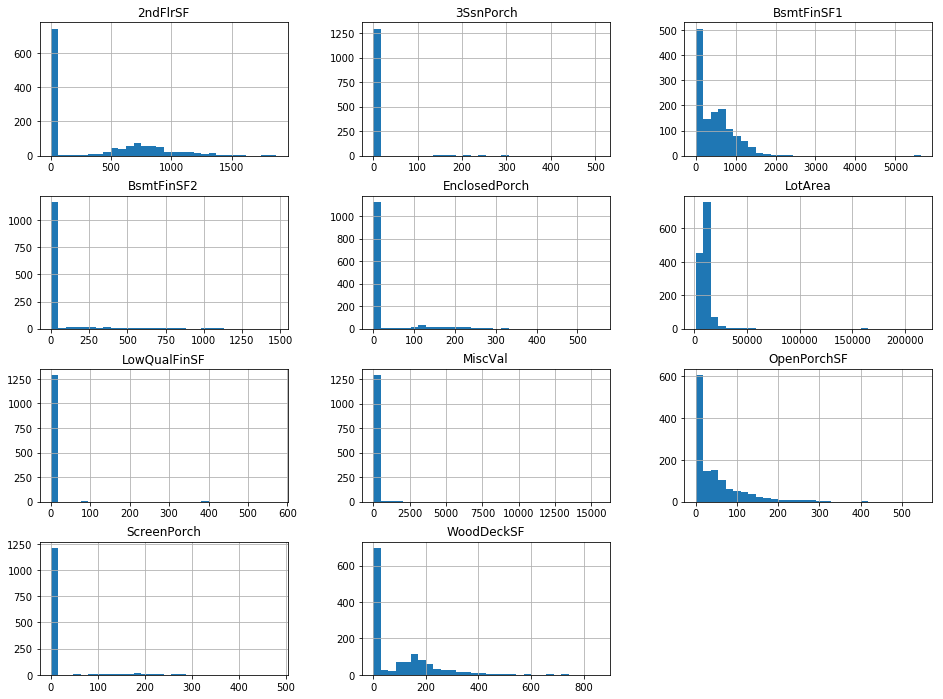

In [29]:
X_train[numerical_remaining].hist(bins=30, figsize=(16,12));

In [30]:
X_train[numerical_with_nan].isna().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
dtype: float64

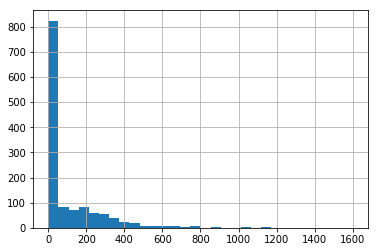

In [31]:
X_train['MasVnrArea'].fillna(X_train['MasVnrArea'].mean()).hist(bins=30)

In [32]:
discrete

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold']

In [33]:
house_pipe = Pipeline([

    # missing data imputation - section 4
#     ('missing_ind',
#      mdi.AddNaNBinaryImputer(
#          variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('positive_numericals', vt.LogTransformer(variables=pos)),
    
    ('YJ', vt.YeoJohnsonTransformer(variables=data_yj)),
    
    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),
        
    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelCategoricalEncoder(tol=0.25, # for some reason (0.25, 4) is offering the best results
                                    n_categories=4,
                                    variables=categorical + discrete)),


    ('categorical_enc',
     ce.OneHotCategoricalEncoder(top_categories=10, variables=categorical + discrete)),
     
    # discretisation + encoding - section 8
    ('discretisation',
     dsc.EqualFrequencyDiscretiser(q=10,
                                   return_object=True,
                                   variables=numerical_remaining)),
    ('encoding',
     ce.OrdinalCategoricalEncoder(encoding_method='ordered',
                                  variables=numerical_remaining)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

#     ('scaler', MinMaxScaler()), # StandardScaler offered better results

    
    # regression
    ('lasso', Lasso(random_state=0))
])

# let's fit the pipeline
house_pipe.fit(X_train, y_train)
s
# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


train mse: 791925590.2787514
train rmse: 28141.17251073152
train r2: 0.8731667338370277

test mse: 1291679350.179898
test rmse: 35939.940876132474
test r2: 0.8120405004425366


C:\Users\Rachit\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Text(0, 0.5, 'Predicted Price')

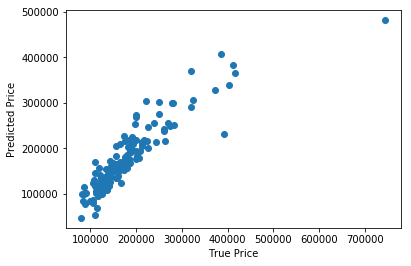

In [34]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')